In [10]:
import sys
sys.path.append('/global/homes/j/jpiat/my_hodpy')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from astropy.table import Table
#from dipole import model
from dipole import Doppler
from dipole import Grav_redshift
from dipole import matter_power_spectrum as Pm
from hodpy.cosmology import CosmologyAbacus
cosmo = CosmologyAbacus(0)  #c000 cosmology
from cosmoprimo import *


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

## Model

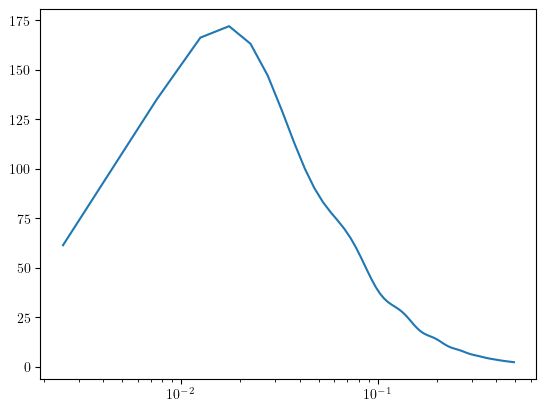

In [11]:
b = [1.5,1]
s = [0.9, 0.3]
z = 0.2

k = np.arange(0,0.5,0.005)[:-1]+0.005/2

plt.figure()
plt.xscale('log')

plt.plot(k, k*2*Doppler(k,z,s,b))

In [12]:
def volume(z):
    
    return 4/3*np.pi*cosmo.comoving_distance(z)**3

def volume_shell(z1, z2):
    
    return volume(z2) - volume(z1)

In [13]:
def model(k,s_b,s_f,b_b,b_f):
    
    z_bins = np.arange(0,0.55,0.05)
    z_eff = z_bins[:-1]+0.05/2
    
    V_tot = volume_shell(z_bins[0], z_bins[-1])
    model = np.zeros(len(k))
    
    for i,z in enumerate(z_eff):
        
        s = [s_b[i],s_f[i]]
        b = [b_b[i],b_f[i]]
        
        V = volume_shell(z_bins[i], z_bins[i+1])
        
        model += 2*Doppler(k,z,s,b)*V/V_tot
        
    return model

In [14]:
def model_eff(k,z,s_b,s_f,b_b,b_f):
        
    s = [s_b,s_f]
    b = [b_b,b_f]
        
    model = 2*np.array(Doppler(k,z,s,b))
    
    return model

In [15]:
def dPm(k,Pm):

    Pm = Pm(k,z=0)
    dPm = np.zeros(len(Pm))
    dPm[1:-1] = (Pm[2:]-Pm[0:-2])/(k[2:]-k[0:-2])
    dPm[0] = (Pm[1]-Pm[0])/(k[1]-k[0])
    dPm[-1] = (Pm[-1]-Pm[-2])/(k[-1]-k[-2])
    
    return dPm

In [16]:
def wide_angles(k,z,b,Pm):
    
    c = 3e5
    D = cosmo.growth_factor(z)
    f = cosmo.growth_rate(z)
    r = cosmo.comoving_distance(z)
    
    Fwa = -(4*f*(7*b+3*f)/(35*r))*D**2
    B2 = -3*Pm(k,z=0)/k-dPm(k,Pm)
    
    return Fwa*B2

In [17]:
def WA_model(k,b_b,b_f,Pm):
    
    z_bins = np.arange(0,0.55,0.05)
    z_eff = z_bins[:-1]+0.05/2
    
    V_tot = volume_shell(z_bins[0], z_bins[-1])
    model = np.zeros(len(k))
    
    for i,z in enumerate(z_eff):
        
        V = volume_shell(z_bins[i], z_bins[i+1])
        
        WA = wide_angles(k,z,b_f[i],Pm)-wide_angles(k,z,b_b[i],Pm)
        model += WA*V/V_tot
        
    return model

In [18]:
def WA_model_eff(k,z,b_b,b_f,Pm):
    
    return wide_angles(k,z,b_f,Pm)-wide_angles(k,z,b_b,Pm)

### BGS/Abacus mocks

In [19]:
def get_dipole_data(path,cut_b,cut_f):

    data_BF = np.loadtxt(path+f'Pk1_bright{cut_b}_faint{cut_f}.dat')
    data_FB = np.loadtxt(path+f'Pk1_faint{cut_f}_bright{cut_b}.dat')
    data_real_BF = np.loadtxt(path+f'Pk1_bright{cut_b}_faint{cut_f}_real.dat')
    data_real_FB = np.loadtxt(path+f'Pk1_faint{cut_f}_bright{cut_b}_real.dat')
        
    pk1_BF = data_BF[:,1]
    pk1_FB = data_FB[:,1]
    pk1_real_BF = data_real_BF[:,1]
    pk1_real_FB = data_real_FB[:,1]
    
    return (pk1_BF-pk1_real_BF)-(pk1_FB-pk1_real_FB)


def mean_dipole(phs,k,cut_b,cut_f):
    
    paths = []
    for ph in phs:
        paths.append(f'/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph00{ph}/cutsky/magnitude_splits/')
    
    Pk1_mean = np.zeros(len(k))
    
    for path in paths:

        print(path)
        Pk1_mean += get_dipole_data(path,cut_b,cut_f)

    return Pk1_mean/len(phs)

def plot_dipole(ph,k,s_b,s_f,b_b,b_f,cut_b,cut_f):
    
    path = f'/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph00{ph}/cutsky/magnitude_splits/'
    
    #labels = ['-2/(rH)','-5s/c','5s/(rH)']

    plt.figure()
        
    Pk1 = get_dipole_data(path,cut_b,cut_f)

    #pk1_model = model(k,s_b,s_f,b_b,b_f)
    #Pwa = wide_angles_model(k,b_b,b_f,Pm)
    
    pk1_model = model_eff(k,0.2,s_b,s_f,b_b,b_f)
    Pwa = WA_model_eff(k,0.2,b_b,b_f,Pm)
    
    plt.plot(k, k*pk1_model, ls ='--',alpha=0.8)
    plt.plot(k, k*Pk1,marker='.',alpha=0.5,label=f'{cut_b}/{cut_f}')
    plt.plot(k, k*(Pwa+pk1_model), ls ='-')
    plt.plot(k, k*Pwa, ls ='-.',alpha=0.8)
        
    plt.title(f'ph00{ph}')
    plt.ylabel(r'k [(P$\rm_1^{BF}$ - P$\rm^{BF,real}_1$) - (P$\rm_1^{FB}$ - P$\rm^{FB,real}_1$)]',fontsize=15)
    plt.xlabel('k [h/Mpc]', fontsize=15)
    plt.xscale('log')
    plt.grid()      
    
    line = Line2D([0], [0], label=r'Doppler', color='k', ls='--')
    line1 = Line2D([0], [0], label=r'WA, z$_{\rm eff}$ = 0.2', color='k', ls='-.')
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.extend([line,line1])
    plt.legend(handles=handles)
    
    plt.show()

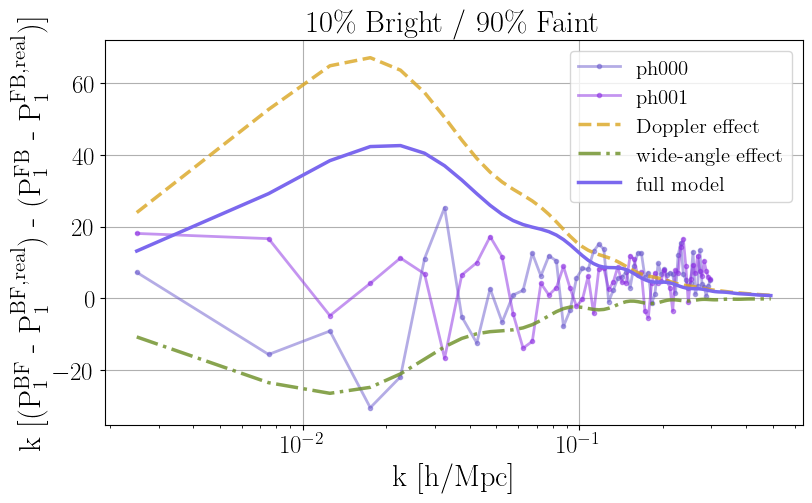

In [16]:
cut_b = 10
cut_f = 90

k = np.arange(0,0.5,0.005)[:-1]+0.005/2

plt.figure(figsize=(9,5))
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('10\% Bright / 90\% Faint',fontsize=22)
plt.ylabel(r'k [(P$\rm_1^{BF}$ - P$\rm^{BF,real}_1$) - (P$\rm_1^{FB}$ - P$\rm^{FB,real}_1$)]',fontsize=22)
plt.xlabel('k [h/Mpc]', fontsize=22)
plt.xscale('log')
plt.grid() 

b_b = [0.8120554981788436, 1.2246975363337866, 1.269776064139231, 1.4444397224995196, 1.5720542840336875, 
       1.7548731161718523, 2.0231506237680663, 2.344423500154111, 2.8070729070159985, 3.5077011759227266]
b_f = [0.6319957227375367, 0.9296739372374704, 1.0292165521430636, 1.1136586627532312, 1.1625959528286096, 
       1.24398834886037, 1.3860413569233831, 1.5007456265428296, 1.6994643042784021, 1.9345141430545325]

s_b = [0.37720954, 0.56522563, 0.70606536, 0.8290184,  0.95391354, 1.10539933, 1.30255305, 1.54092151, 1.81813183, 2.13736479]
s_f = [0.1350212, 0.18190782, 0.17665099, 0.26702187, 0.39204597, 0.54313827, 0.69236816, 0.89125839, 1.17620674, 1.63688239]

path = f'/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cutsky/magnitude_splits/'
        
Pk1 = get_dipole_data(path,cut_b,cut_f)

plt.plot(k, k*Pk1,marker='.',lw=2,alpha=0.5,c='slateblue',label='ph000')

path = f'/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph001/cutsky/magnitude_splits/'

Pk1 = get_dipole_data(path,cut_b,cut_f)
pk1_model = model(k,s_b,s_f,b_b,b_f)
Pwa = WA_model(k,b_b,b_f,Pm)

plt.plot(k, k*Pk1,marker='.',lw=2,alpha=0.5,c='blueviolet',label='ph001')
plt.plot(k, k*pk1_model,ls ='--',lw=2.5,alpha=0.8,c='goldenrod',label='Doppler effect')
plt.plot(k, k*Pwa,ls ='-.',lw=2.5,alpha=0.8,c='olivedrab',label='wide-angle effect')
plt.plot(k, k*(Pwa+pk1_model),ls ='-',lw=2.5,c='mediumslateblue',label='full model')

plt.legend(fontsize=15)

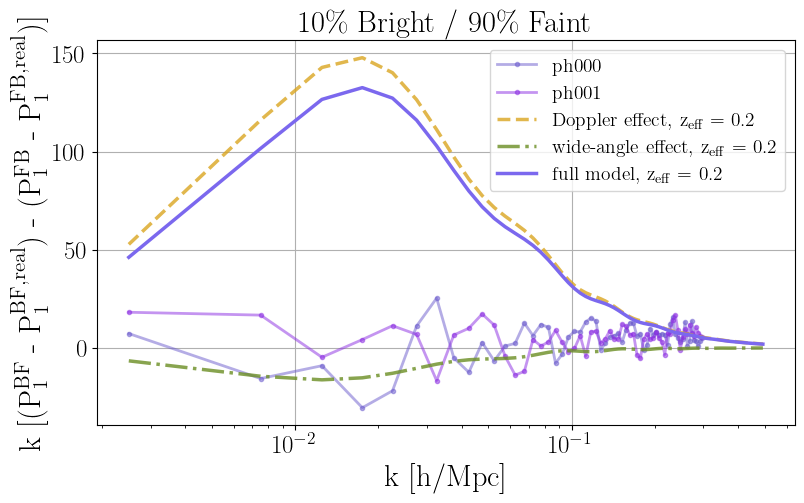

In [24]:
cut_b = 10
cut_f = 90

k = np.arange(0,0.5,0.005)[:-1]+0.005/2

plt.figure(figsize=(9,5))
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('10\% Bright / 90\% Faint',fontsize=22)
plt.ylabel(r'k [(P$\rm_1^{BF}$ - P$\rm^{BF,real}_1$) - (P$\rm_1^{FB}$ - P$\rm^{FB,real}_1$)]',fontsize=22)
plt.xlabel('k [h/Mpc]', fontsize=22)
plt.xscale('log')
plt.grid() 

b_b = 1.37
b_f = 1.06

s_b = 0.98
s_f = 0.42

path = f'/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cutsky/magnitude_splits/'
        
Pk1 = get_dipole_data(path,cut_b,cut_f)

plt.plot(k, k*Pk1,marker='.',lw=2,alpha=0.5,c='slateblue',label='ph000')

path = f'/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph001/cutsky/magnitude_splits/'

Pk1 = get_dipole_data(path,cut_b,cut_f)
pk1_model = model_eff(k,0.21,s_b,s_f,b_b,b_f)
Pwa = WA_model_eff(k,0.21,b_b,b_f,Pm)

plt.plot(k, k*Pk1,marker='.',lw=2,alpha=0.5,c='blueviolet',label='ph001')
plt.plot(k, k*pk1_model,ls ='--',lw=2.5,alpha=0.8,c='goldenrod',label=r'Doppler effect, z$_{\rm eff}$ = 0.2')
plt.plot(k, k*Pwa,ls ='-.',lw=2.5,alpha=0.8,c='olivedrab',label=r'wide-angle effect, z$_{\rm eff}$ = 0.2')
plt.plot(k, k*(Pwa+pk1_model),ls ='-',lw=2.5,c='mediumslateblue',label=r'full model, z$_{\rm eff}$ = 0.2')

plt.legend(fontsize=14)

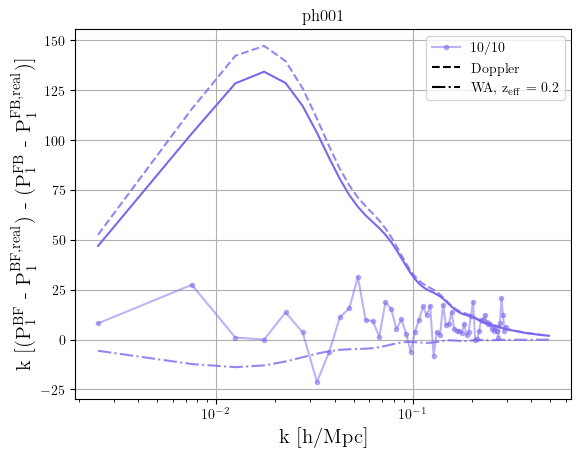

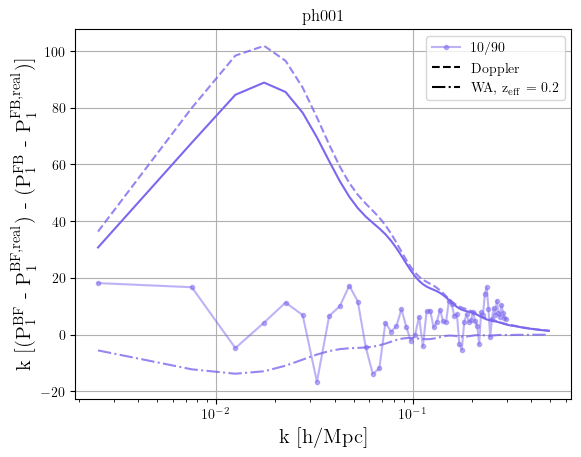

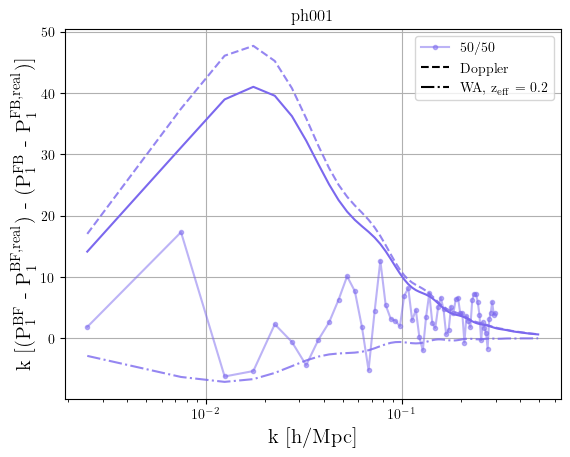

In [21]:
cuts_b = [10,10,50]
cuts_f = [10,90,50]

z = 0.2
k = np.arange(0,0.5,0.005)[:-1]+0.005/2

s = np.array([[0.97,0.28],[0.97,0.415],[0.61,0.34]])
b = np.array([[1.37, 1.06],[1.37,1.06],[1.17,1.01]])

for i, (cb, cf) in enumerate(zip(cuts_b,cuts_f)):

    plot_dipole(1,z,k,s[i,0],s[i,1],b[i],cb,cf)

/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cutsky/magnitude_splits/
/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph001/cutsky/magnitude_splits/
/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cutsky/magnitude_splits/
/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph001/cutsky/magnitude_splits/
/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cutsky/magnitude_splits/
/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph001/cutsky/magnitude_splits/


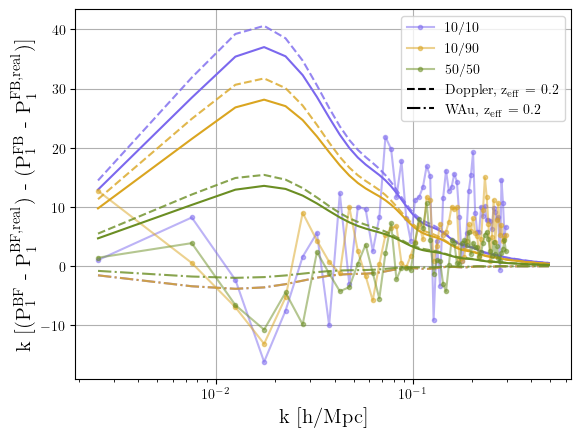

In [9]:
cuts_b = [10,10,50]
cuts_f = [10,90,50]

z = 0.5
k = np.arange(0,0.5,0.005)[:-1]+0.005/2

s = [[0.97,0.28],[0.97,0.415],[0.61,0.34]]
b = np.array([[1.37, 1.06],[1.37,1.06],[1.17,1.01]])


col = ['mediumslateblue','goldenrod','olivedrab']
plt.figure()

for i, (cut_b, cut_f) in enumerate(zip(cuts_b, cuts_f)):
    
    Pk1 = mean_dipole([0,1],k,cut_b,cut_f)

    pk1_model = 2*Doppler(k,z,s[i],b[i])
    Pwa = wide_angles(z,k,b[i,1],Pm)-wide_angles(z,k,b[i,0],Pm)

    plt.plot(k, k*Pk1,marker='.',c=col[i],alpha=0.5,label=f'{cut_b}/{cut_f}')
    plt.plot(k, k*(Pwa+pk1_model), ls ='-', c=col[i])
    plt.plot(k, k*pk1_model, ls ='--',c=col[i],alpha=0.8)
    plt.plot(k, k*Pwa, ls ='-.',c=col[i],alpha=0.8)
    
plt.ylabel(r'k [(P$\rm_1^{BF}$ - P$\rm^{BF,real}_1$) - (P$\rm_1^{FB}$ - P$\rm^{FB,real}_1$)]',fontsize=15)
plt.xlabel('k [h/Mpc]', fontsize=15)
plt.xscale('log')
plt.grid()      

line = Line2D([0], [0], label=r'Doppler, z$_{\rm eff}$ = 0.2', color='k', ls='--')
line1 = Line2D([0], [0], label=r'WAu, z$_{\rm eff}$ = 0.2', color='k', ls='-.')
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([line,line1])
plt.legend(handles=handles)

plt.show()

### MXXL/Abacus mocks

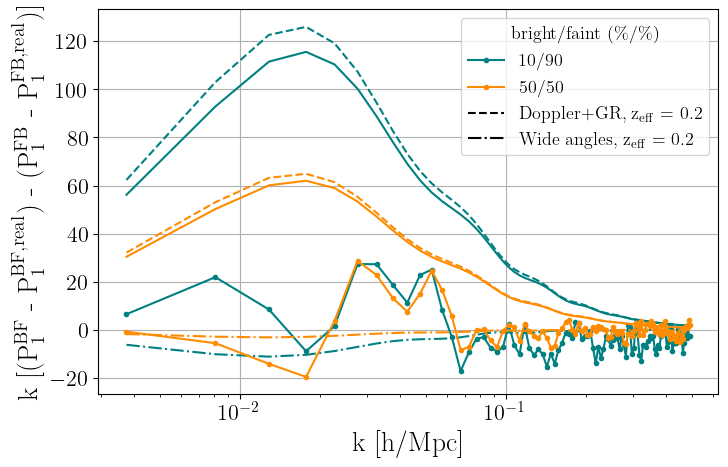

In [23]:
from matplotlib.lines import Line2D

cuts_b = [10,50]
cuts_f = [90,50]

s_b = [0.98,0.62]       
s_f = [0.42,0.33]       # 0.3

b_b = [1.3,1.1]
b_f = [1.05,1.03]       # 1.05

z = 0.2

plt.figure(figsize=(8,5))
plt.xticks(fontsize = 16) 
plt.yticks(fontsize = 16) 

colors = ['teal','darkorange','darkviolet']
    
for i, [cut_b, cut_f] in enumerate(zip(cuts_b, cuts_f)):
    
    data_BF = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_b{cut_b}_f{cut_f}.dat')
    data_FB = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_f{cut_f}_b{cut_b}.dat')
    data_real_BF = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_real_b{cut_b}_f{cut_f}.dat')
    data_real_FB = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_real_f{cut_f}_b{cut_b}.dat')
    
    k = data_BF[:,0]
    k_real = data_real_BF[:,0]
    pk1_BF = data_BF[:,1]
    pk1_FB = data_FB[:,1]
    pk1_real_BF = data_real_BF[:,1]
    pk1_real_FB = data_real_FB[:,1]
    
    s = [s_b[i], s_f[i]]
    b = [b_b[i], b_f[i]]
    
    pk1_model = 2*model(k,z,s,b)
    P_tot = (pk1_BF-pk1_real_BF)-(pk1_FB-pk1_real_FB)
    Pwa = wide_angles(z,k,b_f[i],Pm)-wide_angles(z,k,b_b[i],Pm)
    
    #data = np.zeros((len(k),7))
    #data[:,0] = k
    #data[:,1] = k_real
    #data[:,2] = pk1_BF
    #data[:,3] = pk1_real_BF
    #data[:,4] = pk1_FB
    #data[:,5] = pk1_real_FB
    #data[:,6] = P_tot
    #
    #if cut_f == 90:
    #    np.savetxt('dipole_B10_F90.txt', data)
    #    
    #if cut_f == 10:
    #    np.savetxt('dipole_B10_F10.txt', data)
    
    plt.plot(k, k*P_tot,marker='.',label=f'{cut_b}/{cut_f}',color=colors[i])
    plt.plot(k, k*pk1_model, ls = '--', color=colors[i])
    plt.plot(k, k*Pwa, ls = '-.', color=colors[i])
    plt.plot(k, k*(Pwa+pk1_model), ls = '-', color=colors[i])

line = Line2D([0], [0], label=r'Doppler+GR, z$_{\rm eff}$ = 0.2', color='k', ls='--')
line1 = Line2D([0], [0], label=r'Wide angles, z$_{\rm eff}$ = 0.2', color='k', ls='-.')
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([line,line1])
    
plt.ylabel(r'k [(P$\rm_1^{BF}$ - P$\rm^{BF,real}_1$) - (P$\rm_1^{FB}$ - P$\rm^{FB,real}_1$)]',fontsize=20)
plt.xlabel('k [h/Mpc]', fontsize=20)
plt.xscale('log')
plt.grid()
plt.legend(handles=handles, fontsize=13,title='bright/faint (\%/\%)',title_fontsize=13)
plt.savefig('/global/homes/j/jpiat/Relativistic_effects/figures/dipole.pdf',bbox_inches='tight');

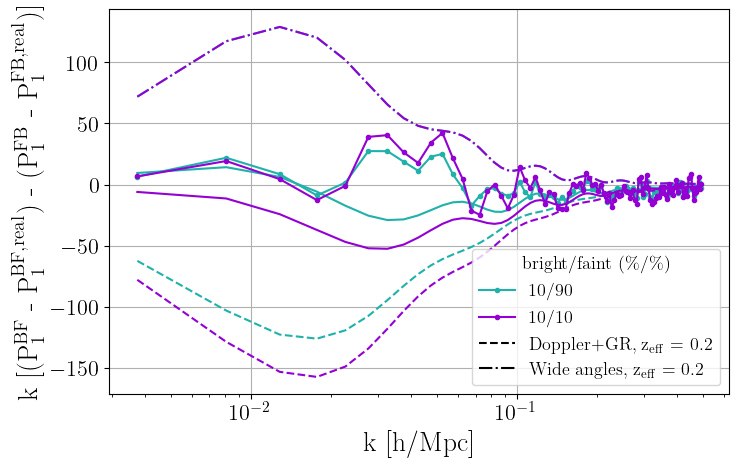

In [14]:
from matplotlib.lines import Line2D

cuts_b = [10,10]
cuts_f = [90,10]

s_b = [0.98,0.98]       
s_f = [0.42,0.30]

b_b = [1.3,1.3]
b_f = [1.05,1.05]

z = 0.2

plt.figure(figsize=(8,5))
plt.xticks(fontsize = 16) 
plt.yticks(fontsize = 16) 

colors = ['lightseagreen','darkviolet']
    
for i, [cut_b, cut_f] in enumerate(zip(cuts_b, cuts_f)):
    
    data_BF = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_b{cut_b}_f{cut_f}.dat')
    data_FB = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_f{cut_f}_b{cut_b}.dat')
    data_real_BF = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_real_b{cut_b}_f{cut_f}.dat')
    data_real_FB = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_real_f{cut_f}_b{cut_b}.dat')
    
    k = data_BF[:,0]
    k_real = data_real_BF[:,0]
    pk1_BF = data_BF[:,1]
    pk1_FB = data_FB[:,1]
    pk1_real_BF = data_real_BF[:,1]
    pk1_real_FB = data_real_FB[:,1]
    
    s = [s_b[i], s_f[i]]
    b = [b_b[i], b_f[i]]
    
    pk1_model = model(k,z,s,b)
    P_tot = (pk1_BF-pk1_real_BF)-(pk1_FB-pk1_real_FB)
    Pwa = wide_angles(z,k,b_f[i],Pm,dPm)+wide_angles(z,k,b_b[i],Pm,dPm)
    
    #data = np.zeros((len(k),7))
    #data[:,0] = k
    #data[:,1] = k_real
    #data[:,2] = pk1_BF
    #data[:,3] = pk1_real_BF
    #data[:,4] = pk1_FB
    #data[:,5] = pk1_real_FB
    #data[:,6] = P_tot
    #
    #if cut_f == 90:
    #    np.savetxt('dipole_B10_F90.txt', data)
    #    
    #if cut_f == 10:
    #    np.savetxt('dipole_B10_F10.txt', data)
    
    plt.plot(k,k*P_tot,marker='.',label=f'{cut_b}/{cut_f}',color=colors[i])
    plt.plot(k, -2*k*pk1_model, ls = '--', color=colors[i])
    plt.plot(k, k*Pwa, ls = '-.', color=colors[i])
    plt.plot(k, k*(Pwa-2*pk1_model), ls = '-', color=colors[i])

line = Line2D([0], [0], label=r'Doppler+GR, z$_{\rm eff}$ = 0.2', color='k', ls='--')
line1 = Line2D([0], [0], label=r'Wide angles, z$_{\rm eff}$ = 0.2', color='k', ls='-.')
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([line,line1])
    
plt.ylabel(r'k [(P$\rm_1^{BF}$ - P$\rm^{BF,real}_1$) - (P$\rm_1^{FB}$ - P$\rm^{FB,real}_1$)]',fontsize=20)
plt.xlabel('k [h/Mpc]', fontsize=20)
plt.xscale('log')
plt.grid()
plt.legend(handles=handles, fontsize=13,title='bright/faint (\%/\%)',title_fontsize=13)
plt.savefig('/global/homes/j/jpiat/Relativistic_effects/figures/dipole.pdf',bbox_inches='tight');

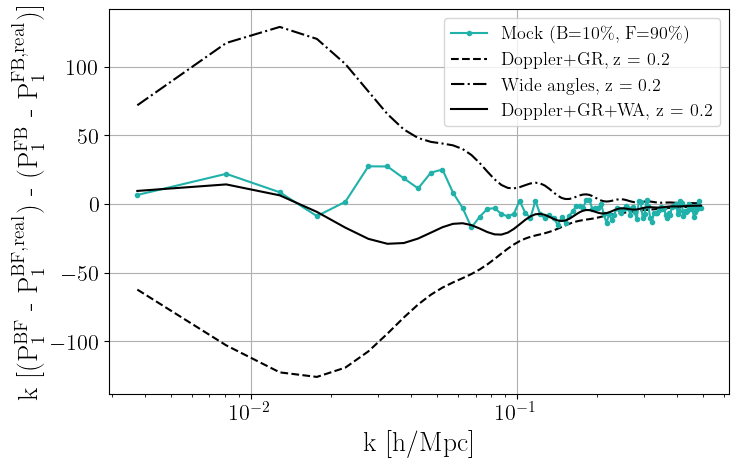

In [13]:
cut_b = 10
cut_f = 90

s_b = 0.98 
s_f = 0.42

b_b = 1.3
b_f = 1.05

z = 0.2

plt.figure(figsize=(8,5))
plt.xticks(fontsize = 16) 
plt.yticks(fontsize = 16) 

i = 0

colors = ['lightseagreen','darkorange','darkviolet']
    
data_BF = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_b{cut_b}_f{cut_f}.dat')
data_FB = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_f{cut_f}_b{cut_b}.dat')
data_real_BF = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_real_b{cut_b}_f{cut_f}.dat')
data_real_FB = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_real_f{cut_f}_b{cut_b}.dat')

k = data_BF[:,0]
k_real = data_real_BF[:,0]
pk1_BF = data_BF[:,1]
pk1_FB = data_FB[:,1]
pk1_real_BF = data_real_BF[:,1]
pk1_real_FB = data_real_FB[:,1]

s = [s_b, s_f]
b = [b_b, b_f]

pk1_model = model(k,z,s,b)
P_tot = (pk1_BF-pk1_real_BF)-(pk1_FB-pk1_real_FB)
Pwa = wide_angles(z,k,b_f,Pm,dPm)+wide_angles(z,k,b_b,Pm,dPm)

plt.plot(k, -2*k*pk1_model, ls = '--', color='k')
plt.plot(k, k*Pwa, ls = '-.', color='k')
plt.plot(k,k*P_tot,marker='.',label='Mock (B=10\%, F=90\%)',color=colors[i])
plt.plot(k,k*(Pwa-2*pk1_model), ls = '-', color='k')

line = Line2D([0], [0], label=r'Doppler+GR, z = 0.2', color='k', ls='--')
line1 = Line2D([0], [0], label=r'Wide angles, z = 0.2', color='k', ls='-.')
line2 = Line2D([0], [0], label=r'Doppler+GR+WA, z = 0.2', color='k', ls='-')
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([line,line1,line2])
    
plt.ylabel(r'k [(P$\rm_1^{BF}$ - P$\rm^{BF,real}_1$) - (P$\rm_1^{FB}$ - P$\rm^{FB,real}_1$)]',fontsize=20)
plt.xlabel('k [h/Mpc]', fontsize=20)
plt.xscale('log')
plt.grid()
plt.legend(handles=handles, fontsize=13)

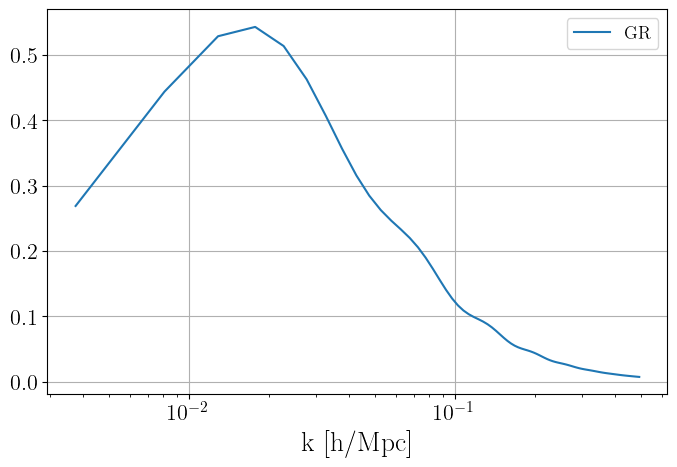

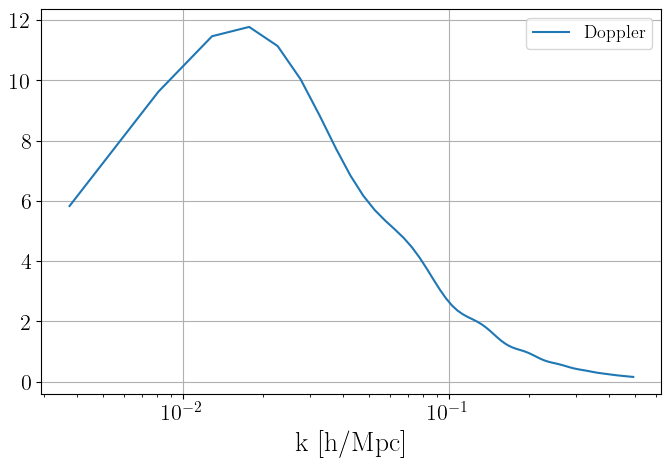

In [10]:
s_b = 0.5 
s_f = 0.4

b_b = 1.3
b_f = 1.05

z = 0.2
s = [s_b, s_f]
b = [b_b, b_f]

P_doppler = Doppler(k,z,s,b)
P_GR = Grav_redshift(k,z,b)

plt.figure(figsize=(8,5))
plt.xticks(fontsize = 16) 
plt.yticks(fontsize = 16) 

plt.plot(k, k*P_GR,label='GR')

plt.xlabel('k [h/Mpc]', fontsize=20)
plt.xscale('log')
plt.grid()
plt.legend(fontsize=13)


plt.figure(figsize=(8,5))
plt.xticks(fontsize = 16) 
plt.yticks(fontsize = 16) 

plt.plot(k, k*P_doppler,label='Doppler')

plt.xlabel('k [h/Mpc]', fontsize=20)
plt.xscale('log')
plt.grid()
plt.legend(fontsize=13)

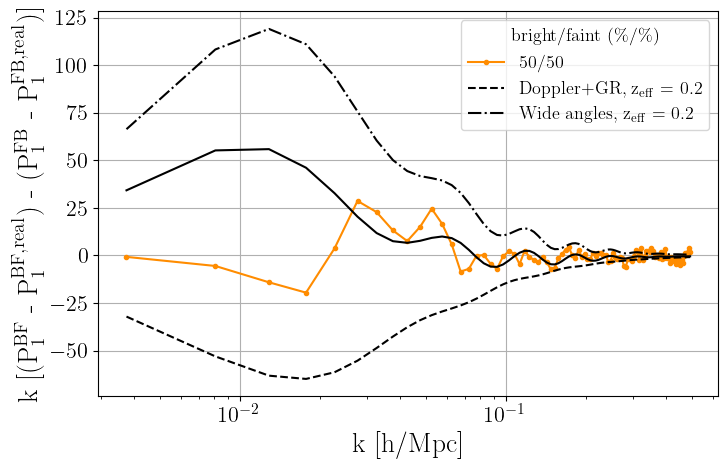

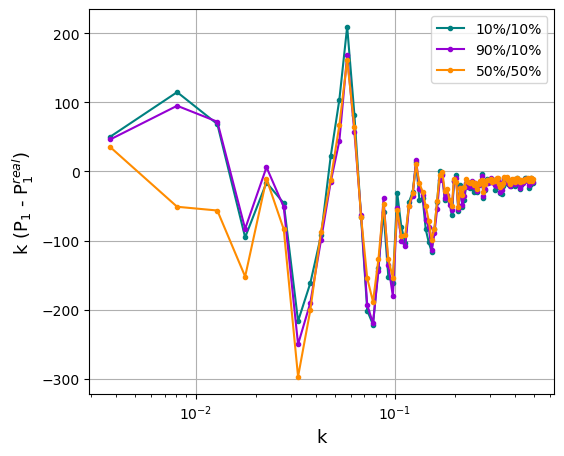

In [4]:
cuts_b = [10,10,50]
cuts_f = [10,90,50]

s_b = [0.98,0.98,0.62]
s_f = [0.3,0.42,0.33]

b_b = [1.3,1.3,1.1]
b_f = [1.05,1.05,1.03]

plt.figure(figsize=(6,5))
colors = ['teal','darkviolet','darkorange']
    
for i, [cut_b, cut_f] in enumerate(zip(cuts_b, cuts_f)):
    
    data = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_b{cut_b}_f{cut_f}.dat')
    
    k = data[:,0]
    pk1_real = data[:,1]
    
    plt.plot(k,k*pk1_real,marker='.',color=colors[i],label=f'{cut_f}%/{cut_b}%')
    
plt.ylabel(r'k (P$_1$ - P$^{real}_1$)',fontsize=13)
plt.xlabel('k', fontsize=13)
plt.xscale('log')
plt.grid()
plt.legend();

[1.04257534e+01 5.17803804e+02 1.96218491e-04 1.04904175e-05]
[6.57145429e+00 6.21247082e+02 1.37090683e-04 8.58306885e-06]
[6.25938153e+00 1.02098945e+03 1.80006027e-04 9.29832458e-06]


Text(0, 0.5, 'time [min]')

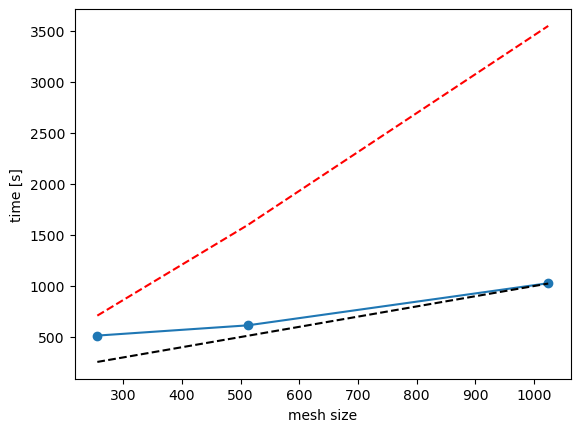

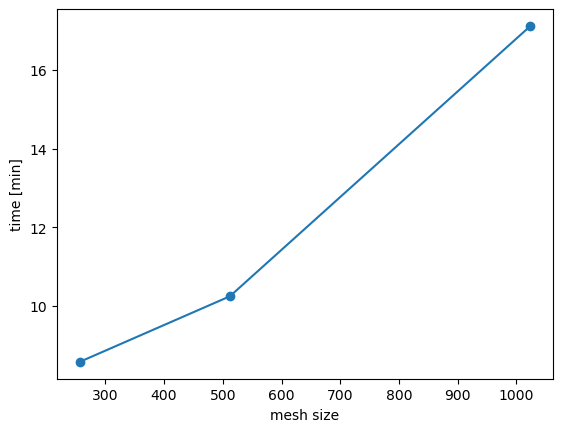

In [33]:
n = np.array([256,512,1024])
time = np.array([514.1038117408752, 614.3950424194336, 1027.4733307361603])

time256 = np.diff([1713914994.4848666, 1713915004.91062, 1713915522.7144237, 1713915522.7146199, 1713915522.7146304])
time512 = np.diff([1713915522.7362378, 1713915529.307692, 1713916150.5547743, 1713916150.5549114, 1713916150.55492])
time51024 = np.diff([1713916150.577391, 1713916156.8367724, 1713917177.826219, 1713917177.826399, 1713917177.8264084])

print(time256)
print(time512)
print(time51024)

plt.figure()
plt.plot(n,time,marker='o')
plt.plot(n,n,'k--')
plt.plot(n,0.5*n*np.log(n),'r--')
plt.xlabel('mesh size')
plt.ylabel('time [s]') 

plt.figure()
plt.plot(n,time/60,marker='o')
plt.xlabel('mesh size')
plt.ylabel('time [min]') 